# Real estate AI agent 
This real estate AI agent will use a chatGPT 3.5 model as foundation model and langchain for content generation, and chromadb as a vector database for semantic search to provide personalized real estate listings. It also includes gradio for a simple UI setup.  

## Environment setup

In [5]:
!pip install -q -r ./requirements.txt

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
from langchain.llms import OpenAI
from langchain.output_parsers import PydanticOutputParser
from langchain.pydantic_v1 import BaseModel, Field, NonNegativeInt
from typing import List
from langchain.prompts import PromptTemplate
from fastapi.encoders import jsonable_encoder
import pandas as pd
from diffusers import DiffusionPipeline, AutoPipelineForText2Image
from diffusers.utils import load_image, make_image_grid
import torch
import PIL
from langchain_experimental.open_clip import OpenCLIPEmbeddings
from langchain.vectorstores import Chroma
import gradio as gr
import os

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

Set up your own OpenAI API key here

In [16]:
os.environ["OPENAI_API_KEY"] = "voc-9330409381266773693123674e44bc5b8d09.34451371"
os.environ["OPENAI_API_BASE"] = "https://openai.vocareum.com/v1"

## Generate Real Estate Listings
Use an OpenAI model (here I use chatGPT 3.5 due to the reason of lower expense) to generate several listings. These listings will be populated to the vector database later

In [3]:
model_name = 'gpt-3.5-turbo'
llm = OpenAI(model_name=model_name, temperature=0)
INSTRUCTION = "Generate ten realistic real estate listings from different neighborhoods."
SAMPLE_LISTING = \
"""
Here's a sample listing:

Address: 1655 N California Blvd #134, Walnut Creek, CA 94596

Price: $689,900

Bedrooms: 2

Bathrooms: 2

Square Footage: 886 sqft

Description: Discover contemporary living in this sophisticated 2-bedroom, 2-bathroom condominium, ideally situated in the heart of Walnut Creek. Spanning 886 square feet, this stylish home offers an open-concept layout with modern finishes and abundant natural light. Perfect for urban professionals or those seeking a low-maintenance lifestyle, this residence is just steps away from vibrant dining, shopping, and entertainment options.

Neighborhood Description: Nestled in the vibrant downtown district of Walnut Creek, this condominium offers an unparalleled blend of urban convenience and suburban charm. Renowned for its upscale shopping and dining scene, Walnut Creek boasts destinations like Broadway Plaza and a host of local boutiques and gourmet restaurants.
"""

/home/student/.local/lib/python3.10/site-packages/langchain_community/llms/openai.py:249: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain_community.chat_models import ChatOpenAI`
  warnings.warn(
/home/student/.local/lib/python3.10/site-packages/langchain_community/llms/openai.py:1070: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain_community.chat_models import ChatOpenAI`
  warnings.warn(


In [4]:
class RealEstateListing(BaseModel):
    address: str = Field(description="Address of the listing")
    price: NonNegativeInt = Field(description="Price of the property in USD")
    bedrooms: NonNegativeInt = Field(description="Number of bedrooms in the property")
    bathrooms: NonNegativeInt = Field(description="Number of bathrooms in the property")
    square_footage: NonNegativeInt = Field(description="Size of the property in square feet")
    description: str = Field(description="Description of the property.") 
    neighborhood_description: str = Field(description="Description of the neighborhood.")  

class ListingCollection(BaseModel):
    listing: List[RealEstateListing] = Field(description="List of available real estate")
        
parser = PydanticOutputParser(pydantic_object=ListingCollection)

prompt = PromptTemplate(
    template="{instruction}\n{sample}\n{format_instructions}\n",
    input_variables=["instruction", "sample"],
    partial_variables={"format_instructions": parser.get_format_instructions},
)
query = prompt.format(instruction = INSTRUCTION, sample = SAMPLE_LISTING)
print(query)

Generate fifteen realistic real estate listings from different neighborhoods.

Here's a sample listing:

Address: 1655 N California Blvd #134, Walnut Creek, CA 94596

Price: $689,900

Bedrooms: 2

Bathrooms: 2

Square Footage: 886 sqft

Description: Discover contemporary living in this sophisticated 2-bedroom, 2-bathroom condominium, ideally situated in the heart of Walnut Creek. Spanning 886 square feet, this stylish home offers an open-concept layout with modern finishes and abundant natural light. Perfect for urban professionals or those seeking a low-maintenance lifestyle, this residence is just steps away from vibrant dining, shopping, and entertainment options.

Neighborhood Description: Nestled in the vibrant downtown district of Walnut Creek, this condominium offers an unparalleled blend of urban convenience and suburban charm. Renowned for its upscale shopping and dining scene, Walnut Creek boasts destinations like Broadway Plaza and a host of local boutiques and gourmet resta

In [5]:
output = llm(query)

/home/student/.local/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


Validate the format of the output

In [6]:
result = parser.parse(output)
df = pd.DataFrame(jsonable_encoder(result.listing))
df.head()

,address,price,bedrooms,bathrooms,square_footage,description,neighborhood_description
0,"123 Main St, San Francisco, CA 94102",1500000,3,2,1800,Charming Victorian home in the heart of San Fr...,Located in the historic neighborhood of Hayes ...
1,"456 Elm St, Brooklyn, NY 11201",1200000,4,3,2200,Spacious brownstone with original features and...,Situated in the desirable neighborhood of Broo...
2,"789 Oak Ave, Austin, TX 78701",800000,2,2,1500,Modern loft-style condo with high ceilings and...,Located in the bustling downtown area of Austi...
3,"101 Pine St, Seattle, WA 98101",950000,1,1,1000,Luxury high-rise apartment with panoramic view...,"Situated in the heart of downtown Seattle, clo..."
4,"555 Maple Ave, Denver, CO 80202",700000,3,2,1800,Contemporary townhouse with a rooftop deck and...,"Located in the trendy neighborhood of LoDo, kn..."


In [7]:
# store generated data to csv
df.to_csv('listings.csv',index_label = 'id')

## Generate Property Image

In [2]:
# load our listings stored in the csv
df = pd.read_csv('listings.csv')

In [3]:
df

,id,address,price,bedrooms,bathrooms,square_footage,description,neighborhood_description
0,0,"123 Main St, San Francisco, CA 94102",1500000,3,2,1800,Charming Victorian home in the heart of San Fr...,Located in the historic neighborhood of Hayes ...
1,1,"456 Elm St, Brooklyn, NY 11201",1200000,4,3,2200,Spacious brownstone with original features and...,Situated in the desirable neighborhood of Broo...
2,2,"789 Oak Ave, Austin, TX 78701",800000,2,2,1500,Modern loft-style condo with high ceilings and...,Located in the bustling downtown area of Austi...
3,3,"101 Pine St, Seattle, WA 98101",950000,1,1,1000,Luxury high-rise apartment with panoramic view...,"Situated in the heart of downtown Seattle, clo..."
4,4,"555 Maple Ave, Denver, CO 80202",700000,3,2,1800,Contemporary townhouse with a rooftop deck and...,"Located in the trendy neighborhood of LoDo, kn..."
5,5,"222 Cherry St, Miami, FL 33130",600000,2,2,1400,Waterfront condo with a private balcony and re...,Situated in the exclusive neighborhood of Bric...
6,6,"777 Walnut St, Philadelphia, PA 19106",850000,4,3,2000,Historic row home with original details and a ...,Located in the charming neighborhood of Societ...
7,7,"333 Cedar St, Portland, OR 97201",750000,2,2,1600,Craftsman-style bungalow with a covered porch ...,Situated in the eclectic neighborhood of Nob H...
8,8,"999 Pineapple St, Honolulu, HI 96813",1200000,3,2,1800,Tropical retreat with ocean views and a lush l...,Located in the prestigious neighborhood of Dia...
9,9,"444 Peachtree St, Atlanta, GA 30303",500000,1,1,900,Modern condo with floor-to-ceiling windows and...,Situated in the bustling downtown area of Atla...


In [4]:
device = "cuda"
pipe = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/sdxl-turbo", 
    torch_dtype=torch.float16, 
    variant="fp16"
).to(device)

/home/student/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
prompt = "A photo for real estate listing with the following property and neighborhood description:\n{}\n\n{}"
rand_gen = torch.manual_seed(851357)

images = []
for i, row in df.iterrows():
    custom_prompt = prompt.format(row['description'], row['neighborhood_description'])
    image = pipe(
        prompt=custom_prompt, 
        num_inference_steps=3, # For normal Stable Diffusion you should use 25 or 50
        guidance_scale=1.0, # For normal Stable Diffusion you should use 6 or 7, or up to 10 or so
        negative_prompt=[], 
        generator=rand_gen
    ).images[0]
    images.append(image)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Check several generated images for validation

Description: Craftsman-style bungalow with a covered porch and a detached studio.
Neighborhood Description: Situated in the eclectic neighborhood of Nob Hill, close to local cafes and boutique shops.


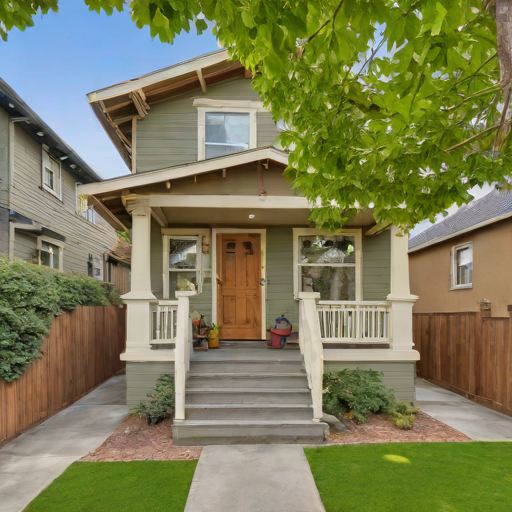

In [6]:
idx = 7
print('Description:', df.iloc[idx]['description'])
print('Neighborhood Description:', df.iloc[idx]['neighborhood_description'])
images[idx] 

Description: Modern condo with floor-to-ceiling windows and city skyline views.
Neighborhood Description: Situated in the bustling downtown area of Atlanta, close to cultural attractions and entertainment venues.


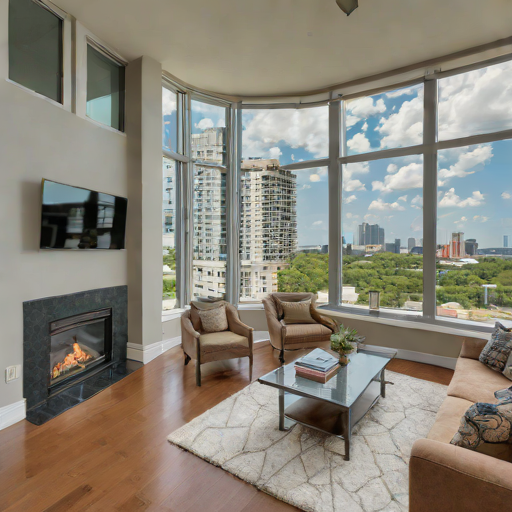

In [7]:
idx = 9
print('Description:', df.iloc[idx]['description'])
print('Neighborhood Description:', df.iloc[idx]['neighborhood_description'])
images[idx] 

In [8]:
images_dir = 'images'

# Create image directory
if not os.path.exists(images_dir):
    os.makedirs(images_dir)
# Save each image
for i, image in enumerate(images):
    filename = os.path.join(images_dir, str(i) + ".png")
    image.save(filename)

## Multimodal Vector Store and Embeddings
After generating property descriptions and images, now we have associated text information and images for each listed property. 

In [9]:
images_dir = 'images'
images = []
text_template = \
"""
Description: {}
Neighborhood Description: {}
Price: {}
Bedrooms: {}
Bathrooms: {}
Square Footage: {}
"""

df = pd.read_csv('listings.csv')
image_paths = []
texts = []
ids = [{'id':i} for i in range(len(df.index))]

for i, row in df.iterrows():
    image_file = os.path.join(images_dir, str(i) + ".png")
    images.append(PIL.Image.open(image_file))
    image_paths.append(image_file)
    texts.append(text_template.format(row['description'],
                               row['neighborhood_description'],
                               row['price'],
                               row['bedrooms'],
                               row['bathrooms'],
                               row['square_footage']))

Use the CLIP Embeddings[https://python.langchain.com/docs/integrations/text_embedding/open_clip/] in LangChain to map both modalities to the same embedding space so we can compare them semantically. 

In [10]:
# Create vector store
db = Chroma(
    collection_name="listings", embedding_function=OpenCLIPEmbeddings()
)

# Add text information
db.add_texts(texts=texts, metadatas = ids)

# Add image information
db.add_images(uris=image_paths, metadatas = ids)

/home/student/.local/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


open_clip_pytorch_model.bin:   0%|          | 0.00/3.94G [00:00<?, ?B/s]

['33eb5204-d0d2-4f06-9f5e-b3be068bd321',
 'ded9b7b3-2f78-46d7-bde8-ee670e1751db',
 '18ac1ee8-ce7d-4b7b-8b6e-83d98a96077e',
 'be9132e6-40e1-4486-96be-d32ed35129f5',
 '4aed5860-c832-48a2-954a-f6073889e685',
 'ef51dddc-e215-4c87-93e4-781ec4ee3560',
 'a7d2ea7b-165c-4f61-8710-ecd59070258a',
 'a9a24013-bfa7-436c-be21-85479759faf5',
 '6029242d-1fc2-4f18-a64c-311a154649d7',
 '35e43106-71b1-4339-b2da-71fc4be1c17c']

In [11]:
res = db.similarity_search("", k=50)

## Personalize the search result based on semantic search

In [12]:
# Ask users following questions to get their personalized search result

QUESTIONS = [   
                "What many bedrooms and bathrooms do you want your house to be?",
                "What are top three considerations in choosing this property?", 
                "Which amenities would you like?", 
                "Which transportation options are important to you?",
                "How urban do you want your neighborhood to be?",   
            ]

In [13]:
def get_top_listings(preferences: list[str], top_k: int=3) -> list[int]:
    '''
    Returns the ids of the top k listing 
    '''
    top_listings = []
    combined_pref = '\n'.join(preferences)
    
    result = db.similarity_search(combined_pref, k=top_k*2)
    for res in result:
        # skip if it's image r text counterpart is already considered
        # in the ranking
        if res.metadata['id'] in top_listings:
            continue
        top_listings.append(res.metadata['id'])
        
        # already gotten top listings
        if len(top_listings) == top_k:
            break
    return top_listings


Description: Craftsman-style bungalow with a covered porch and a detached studio.
Neighborhood Description: Situated in the eclectic neighborhood of Nob Hill, close to local cafes and boutique shops.
Price: 750000
Bedrooms: 2
Bathrooms: 2
Square Footage: 1600



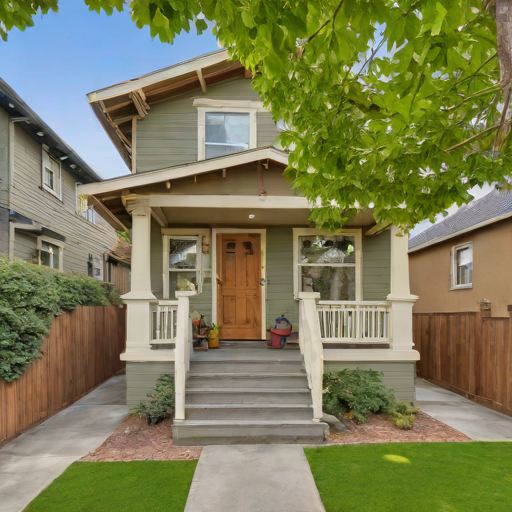

In [14]:
ANSWERS = [
                "Two bedrooms and two bathrooms.",
                "A quiet neighborhood, good local schools, and groceries nearby.",
                "A backyard or patio for resting, a two-car garage, and a properly functioning heating system.",
                "Easy access to a public transit and a major highway.",
                "A balance between suburban tranquility and access to urban amenities like restaurants and theaters."
          ]
res = get_top_listings(ANSWERS)

# check top listing
print(texts[res[0]])
images[res[0]]

## Further improve the personalization

In [17]:
model_name = 'gpt-3.5-turbo'
llm = OpenAI(model_name=model_name, temperature=0)

INSTRUCTION = \
"""
Create a short statement for each listing to attract the buyer given their preferences. Try to emphasize and rephrase what the buyer wants.
"""

/home/student/.local/lib/python3.10/site-packages/langchain_community/llms/openai.py:249: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain_community.chat_models import ChatOpenAI`
  warnings.warn(
/home/student/.local/lib/python3.10/site-packages/langchain_community/llms/openai.py:1070: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain_community.chat_models import ChatOpenAI`
  warnings.warn(


In [18]:
class PersonalizedSummary(BaseModel):
    id: int = Field(description="ID of the listing")
    summary: str = Field(description="Generated personalized summaries")

class SummaryCollection(BaseModel):
    summaries: List[PersonalizedSummary] = Field(description="List of generated personalized summaries")
        
parser = PydanticOutputParser(pydantic_object=SummaryCollection)
prompt = PromptTemplate(
    template="{instruction}\nBuyer Preferences:\n{buyer_preferences}\nListings:\n{listings}\n\n{format_instructions}",
    input_variables=["instruction", "buyer_preferences", "listings"],
    partial_variables={"format_instructions": parser.get_format_instructions},
)

In [19]:
cached_summary = {}

def personalize_top_listings(preferences: list[str], top_k: int=3) -> list:
    '''
    Returns a dictionary of personalized description of the listings based
    in user preference
    '''
    # Get the top related listings first
    res = get_top_listings(preferences, top_k)
    top_texts = []
    for idx in res:
        top_texts.append(''.join(['ID:' + str(idx), texts[idx]]))
        
    query = prompt.format(instruction = INSTRUCTION, 
                          buyer_preferences = '\n'.join(preferences),
                          listings = '\n'.join(top_texts))
    output = []
    for summary in parser.parse(llm(query)).summaries:
        output.append((summary.id,summary.summary))
        cached_summary[summary.id] = summary.summary
    return output

In [20]:
ANSWERS = [
                "A spacious living room",
                "Easy traveling",
                "",
                "",
                ""
          ]
ans = personalize_top_listings(ANSWERS)
ans

/home/student/.local/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


[(9,
  'Modern condo with floor-to-ceiling windows and city skyline views, perfect for a spacious living room and easy access to cultural attractions in downtown Atlanta.'),
 (3,
  "Luxury high-rise apartment with panoramic city and Puget Sound views, ideal for a spacious living room and convenient location near downtown Seattle's Pike Place Market."),
 (5,
  'Waterfront condo with a private balcony and resort-style amenities in Brickell, offering a spacious living room and close proximity to luxury shopping and dining options.')]

## User Interface
Use gradio to implement a simple UI for users to interact with. 

In [21]:
# Auxiliary event handling methods
def set_sr_tab(request: gr.Request):
    return gr.Tabs(selected=1)

def get_select_index(evt: gr.SelectData):
    listing_id = int(evt._data['value']['image']['orig_name'].split('.')[0])
    return cached_summary[listing_id]

# Fetch personalized listings from user preference
def get_search_result(state, answer0, answer1, answer2, answer3, answer4):
    state = 1
    #ans = personalize_top_listings([answer0, answer1, answer2, answer3, answer4])
    search_results = []
    for id, summary in personalize_top_listings([answer0, answer1, answer2, answer3, answer4]):
        search_results.append((image_paths[id], df.iloc[id]['neighborhood']))
    return [gr.update(selected=state), state, search_results]


# Draw layout of the Graphical User Interface
with gr.Blocks() as demo:
    label = gr.Label("Real Estate AI Agent")

    with gr.Tabs() as tabs:
        state = gr.State(0)
        with gr.TabItem("Buyer's Preference", id=0):
            # Create textbox for each question for free-form response
            answers = [] 
            for i in range(len(QUESTIONS)):
                answers.append(gr.Textbox(label=QUESTIONS[i]))
            btn = gr.Button("Submit", scale=0)
    
        # Search results panel
        with gr.TabItem("Search Results", id=1):
            with gr.Row():
                with gr.Column():
                    gallery = gr.Gallery(
                        label="Recommendation", show_label=True, elem_id="gallery", 
                        columns=[3], rows=[2], object_fit="contain", height="auto", 
                        allow_preview=True)
        
                with gr.Column():
                    personalized_desc = gr.Label(label="Personalized Description")
                    #personalized_desc = gr.Label(label="Original Description")
             
    
    # Set event handling
    btn.click(fn=get_search_result, 
              inputs=[state] + [answers[i] for i in range(len(QUESTIONS))], 
              outputs=[tabs, state, gallery])

    gallery.select(get_select_index, 
                   None, 
                   outputs=personalized_desc)

IMPORTANT: You are using gradio version 4.19.2, however version 4.44.1 is available, please upgrade.
--------


In [22]:
# launch the UI
if __name__ == "__main__":
    demo.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
